(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import lfilter, butter
from itertools import product

In [2]:
import reconstructionutils as ru
import cutility as cu

In [3]:
#from scipy.interpolate import splev, splrep

# The fit 
One wants to obtain coefficients $\vec{p}$ of a function $f(\vec{x};\vec{p})$ from minimizing the following term:

$$
\frac{1}{\sum_i^n w_i}\sum_i^n w_i (f(\vec{x};\vec{p})-z_i)^2
$$

Wich can be done by


$$
\frac{\partial}{\partial p_k}\sum_i^n w_i (f(\vec{x};\vec{p})-z_i)^2 = \sum_i^n w_i (f(\vec{x};\vec{p})-z_i)\frac{\partial}{\partial p_k}f(\vec{x};\vec{p})=0
$$

When written as a matrix equation $A\vec{x}=b$:

$$
\begin{pmatrix}
\sum_i^n w_i \cdot x_{1,i}^2 & \sum_i^n w_i \cdot x_{1,i} x_{2,1} & \dots & & \\
\sum_i^n w_i \cdot x_{1,i} x_{2,i} & \ddots\\
\vdots \\
\\
\\
\end{pmatrix}
\cdot
\vec{p}
=
\begin{pmatrix}
\sum_i^n w_i \cdot z_i x_{1,i} \\
\sum_i^n w_i \cdot z_i x_{2,i} \\
\vdots \\
\\
\\
\end{pmatrix}
$$

Using a weighting function $w$.

In [4]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [5]:
# since there is an offset between s[0] and s[-1] one needs to manipulate
# the series that is is truly periodical. this is achieved by tilting the series
tilt_series = lambda t, z: z[t] - (z[-1] - z[0]) * t / len(z)

In [6]:
# original time series
# selected by correlation analysis
z_1_original = np.array(data['E1'])
z_2_original = np.array(data['W3'])
z_3_original = np.array(data['W4'])

timesteps_ = data['time']

series_original = [z_1_original, z_2_original, z_3_original]

In [7]:
# spline the series
#w = np.ones(z_1_original.shape[0])#
#s = 10
#
#t_ = np.linspace(0, len(timesteps_), 1000)
#
#series_spline = []
#series_derivate = []
#for el in series_original:
#    spl = splrep(timesteps_, el, w=w, k=5, s=s)
#    
#    yspl = splev(t_, spl)
#    dyspl = splev(t_, spl, der=1)
#    
#    series_spline.append(yspl)
#    series_derivate.append(dyspl)

In [8]:
# procedure:
# 1. tilt the series, make it full periodical
# 2. filter the series, lowpass filter
# 3. add offset to each series
# 4. tilt it the second time
# 5. cut into intervals

In [9]:
# 1. tilt
z_1_periodical = tilt_series(np.arange(0, len(z_1_original)), z_1_original)
z_2_periodical = tilt_series(np.arange(0, len(z_2_original)), z_2_original)
z_3_periodical = tilt_series(np.arange(0, len(z_3_original)), z_3_original)

In [10]:
# 2. filter the signals with a lowpass to remove unwanted jitter
b, a = butter(3, .01)  # 0.83 cutoff -> 50 Hz, .0415 -> 25 Hz, 0.027 -> ca. 16 Hz
#b, a = butter(3, .008)

z_1_filtered = lfilter(b, a, z_1_periodical)
z_2_filtered = lfilter(b, a, z_2_periodical)
z_3_filtered = lfilter(b, a, z_3_periodical)

In [21]:
# 3. add offset
z_1_filtered += 0
z_2_filtered += -1e-1  # -1e-1
z_3_filtered += 1e-1  # 1e-1

In [22]:
# 4. second time tilting
z_1_ = tilt_series(np.arange(0, len(z_1_filtered)), z_1_filtered)
z_2_ = tilt_series(np.arange(0, len(z_2_filtered)), z_2_filtered)
z_3_ = tilt_series(np.arange(0, len(z_3_filtered)), z_3_filtered)

In [23]:
z_1_derivate_full = cu.first_order_upwind(z_1_)
z_2_derivate_full = cu.first_order_upwind(z_2_)
z_3_derivate_full = cu.first_order_upwind(z_3_)

series_full = [z_1_, z_2_, z_3_]
series_derivate_full = [z_1_derivate_full, z_2_derivate_full, z_3_derivate_full]

In [24]:
# DEBUG
# using SPLINE here
#series_full = series_spline
#series_derivate_full = series_derivate

In [258]:
intervals = [(0, 160),
             (160, 280),    
             (280, 310),
             (310, 330),
             (330, 350),
             
             #(350, 370),
             (350, 470),
             #(370, 470),
             
             #(470, 510),
             (470, 550),
             #(510, 550),
             
             #(550, -1),
             (550, 570),
             (570, -1),
            ]  # (min, max) # this works!

#k = lambda c: int((c / len(z_1_)) * len(series_full[0])) if c != -1 else -1
#intervals = [(k(li), k(gi)) for li, gi in intervals]

# having a interval change every ten steps
#intervals = []
#interval_size = 97
#for i in range(len(series_full[0])):
#    if i % interval_size == 0:
#        intervals.append((i, i + interval_size))

#intervals = [(0,-1)]

In [271]:
series_intervals = []
for i in range(len(intervals)):
    li, gi = intervals[i]
    
    # create weighting function
    #blend = 3
    #amplitude = .15  # plus from normal level (1)
    #weighting = np.ones(np.shape(z_1_[li:gi])) + np.asarray([amplitude if \
    #                                                                     len(z_1_[li:gi]) - blend <= i \
    #                                                                   or \
    #                                                                     i < blend \
    #                                                                   else 0 \
    #                                                         for i in range(len(z_1_[li:gi]))])
    weighting = np.ones(np.shape(series_full[0][li:gi]))
    weighting[-10:] = 2.1
    #weighting[-1] = 2.#10.
    weighting[0] = 2.
    
    #if li not in (80, 170, 180, 220, 230, 340, 360, 390, 500):
    #    weighting[-1] = 1.1
    #if li in (260, 270, 350, 370, 570):
    #    weighting[-1] = 1.05
    #if li in (400,):
    #    weighting[-1] = 1.15
    #if li in (590,):
    #    weighting[0] = 1.05
    #    weighting[-1] = 1.015
    
    if gi == -1:
        weighting[-10:] *= 3.
        weighting[-1] = 3.2

    series_intervals.append([[
                              series_full[0][li:gi],  # system time series (interval)
                              series_full[1][li:gi],
                              series_full[2][li:gi],
                             ],
                             [
                              series_derivate_full[0][li:gi],  # system time series derivates (cut from full)
                              series_derivate_full[1][li:gi],
                              series_derivate_full[2][li:gi],
                             ],
                             timesteps_[li:gi],  # timesteps for interval
                             weighting,  # weighting function for interval
                            ]
                           )

<IPython.core.display.Javascript object>


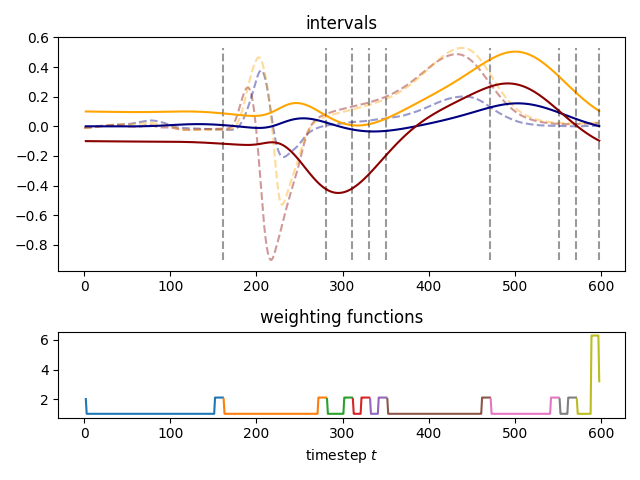

<ipython-input-272-b9f3fb790c17>:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


In [272]:
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 6)

f_ax1 = fig.add_subplot(gs[:4, :])
f_ax1.set_title('intervals')
f_ax1.plot(z_1_original, c='navy', linestyle='--', alpha=.4, label='$z_1$ original')
f_ax1.plot(z_2_original, c='darkred', linestyle='--', alpha=.4, label='$z_2$ original')
f_ax1.plot(z_3_original, c='orange', linestyle='--', alpha=.4, label='$z_3$ original')
for i in range(len(series_intervals)):
    el = series_intervals[i]
    series = el[0]
    
    f_ax1.plot(el[2], series[0], c='navy', label='$z_1$ interval %i' % (i))
    f_ax1.plot(el[2], series[1], c='darkred', label='$z_2$ interval %i' % (i))
    f_ax1.plot(el[2], series[2], c='orange', label='$z_3$ interval %i' % (i))
    
    f_ax1.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
               c='black', alpha=.4, linestyle='--')

f_ax2 = fig.add_subplot(gs[4:, :], sharex=f_ax1)
f_ax2.set_title('weighting functions')
for i in range(len(series_intervals)):
    el = series_intervals[i]
    f_ax2.plot(el[2], el[3])
f_ax2.set_xlabel('timestep $t$')
    
fig.tight_layout()
fig.show()

In [273]:
DEBUG = False

def debug_retrieve_fit_coefficients(self, z: list):
        '''
        parameters:
            - <1d-array> z: target time series to be fitted to
        '''
        print('- DEBUG function -')
        debug_output_a = ''
        
        polynominal_exponents = cu.polynominal(self.dimension, self.grade)
    
        len_polynominal = len(polynominal_exponents[0])
    
        a = np.ones((len_polynominal, len_polynominal))
        for i in range(len_polynominal):
            for j in range(len_polynominal):
                tmp = np.ones(np.shape(self.series[0]))
                for k in range(self.dimension):
                    y = self.series[k]
                    tmp *= y ** (polynominal_exponents[k][j] + polynominal_exponents[k][i])
                    
                    debug_output_a += '%i-' % ((polynominal_exponents[k][j] + polynominal_exponents[k][i]))
                    
                tmp *= self.weighting  # DEBUG: weighting here
                
                a[i][j] *= np.sum(tmp)
                
                debug_output_a += '| '
            debug_output_a += '\n'
        debug_output_b = ''
        
        b = np.ones((len_polynominal, 1))
        for i in range(len_polynominal):
            tmp = np.ones(np.shape(self.series[0]))
            for k in range(self.dimension):
                y = self.series[k]
                tmp *= y ** polynominal_exponents[k][i]
                
                debug_output_b += '%i-' % (polynominal_exponents[k][i])
            debug_output_b +='\n'
                
            tmp *= self.weighting  # DEBUG: weighting here
            b[i] *= np.sum(z * tmp)
            
        if DEBUG:
            print('a:')
            print(debug_output_a)
            print('A:')
            print(a == 0.)
            print('b:')
            print(debug_output_b)
            
        return np.linalg.solve(a, b)

ru.Model._retrieve_fit_coefficients = debug_retrieve_fit_coefficients

In [274]:
grade = 2

In [275]:
models = []

for i in range(len(series_intervals)):
    #if i == 1:
    #    break
    
    series = series_intervals[i][0]
    series_derivate = series_intervals[i][1]
    series_timeframe = list(series_intervals[i][2])
    series_weighting = series_intervals[i][3]

    f = 1024
    reconstruction_timeframe = np.linspace(series_timeframe[0], series_timeframe[-1], len(series_timeframe) * f)
    
    system = ru.Model(series, grade=grade, derivate=series_derivate, weighting=series_weighting)
    
    ivp = None 
    # this snippet is for continous integration, e.g. having the last result as ivp for next interval.
    # its kinda the same as below but with intrinsically hard gammas, which can not be changed.
    if i > 0 and 1:
        ivp = [models[-1][0].solution.T[0][-1],
               models[-1][0].solution.T[1][-1],
               models[-1][0].solution.T[2][-1]]
        
    res = system.evaluate(ivp=ivp)
    
    models.append([
                   system,
                   series_timeframe,
                   reconstruction_timeframe,
                  ])

- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
no initial values defined.
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static


/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
- DEBUG function -
using 3d static
using 3d static
using 3d static
using 3d static


<IPython.core.display.Javascript object>


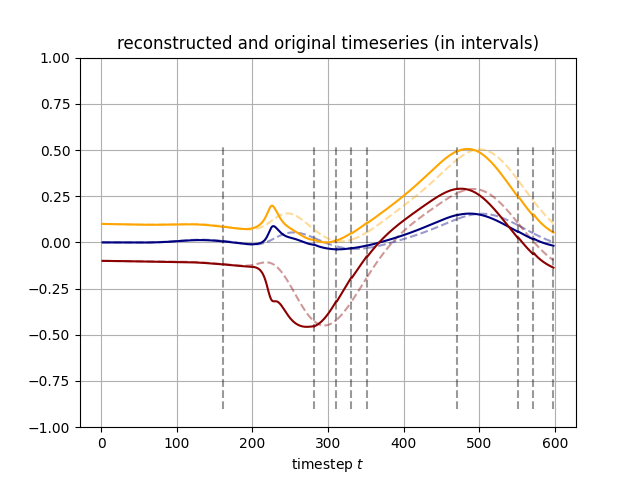

In [276]:
%matplotlib notebook
for el in models:
    plt.plot(el[1], el[0].series[0], linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
    plt.plot(el[1], el[0].series[1], linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
    plt.plot(el[1], el[0].series[2], linestyle='--', alpha=.4, label='$z_3$ original', c='orange')

    plt.plot(el[2], el[0].solution.T[0], label='$z_1$ reconstructed', c='navy')
    plt.plot(el[2], el[0].solution.T[1], label='$z_2$ reconstructed', c='darkred')
    plt.plot(el[2], el[0].solution.T[2], label='$z_3$ reconstructed', c='orange')
    
    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
               c='black', alpha=.4, linestyle='--')

plt.title('reconstructed and original timeseries (in intervals)')
plt.xlabel('timestep $t$')
plt.grid()

plt.ylim([-1, 1])

#plt.legend()
plt.show()

In [277]:
t = np.linspace(0, len(z_1_original), 2000)

In [278]:
gamma = []

epsilon = .5  # below gamma shall return 0
linear_fade_in_duration = 3#2e-9 #20

for i in range(len(intervals)):
    li = intervals[i][0]
    gi = intervals[i][1]

    if gi == -1:
        gi = len(z_1_original) + 100
    if li == 0:
        li = -100

    o = (np.arctan(t - li) - np.arctan(t - gi))
    o_max = np.max(o)


    def _1(t, i=i, li=li, gi=gi, o_max=o_max):
        #tmp = (np.arctan(t - li) - np.arctan(t - gi)) / o_max
        #return tmp * (tmp > epsilon)
        
        if li + (linear_fade_in_duration / 2) <= t <= gi - (linear_fade_in_duration / 2):
            return 1.
        elif li - (linear_fade_in_duration / 2) < t < li + (linear_fade_in_duration / 2):
            return (t - li - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration) + 1
        elif gi - (linear_fade_in_duration / 2) < t < gi + (linear_fade_in_duration / 2):
            return - (t - gi - (linear_fade_in_duration / 2)) * (1 / linear_fade_in_duration)
        else:
            return 0.
    
    gamma.append(_1)

<IPython.core.display.Javascript object>


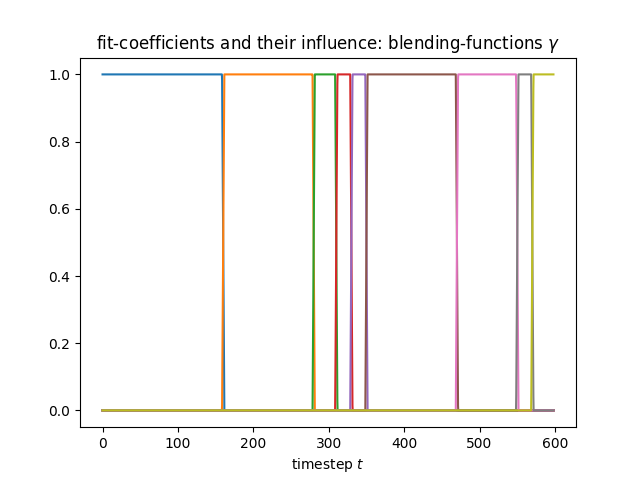

In [279]:
%matplotlib notebook
for el in gamma:
    plt.plot(t, [el(sel) for sel in t])
plt.title('fit-coefficients and their influence: blending-functions $\gamma$')
plt.xlabel('timestep $t$')
plt.show()

In [280]:
time_dependent_fit_coefficients = [[], [], []]

for i in range(len(models[0][0].fit_coefficients)):  # 3: p,q,r
    for j in range(len(models[0][0].fit_coefficients[i])):  # 34: p_0, ..., p_33
        #print(j)
        def _2(t, i=i, j=j):
            res = 0
            for k in range(len(gamma)):  # 8
                #print(i, j, k, np.shape(res))
                res += gamma[k](t) * models[k][0].fit_coefficients[i][j]
            return res
        time_dependent_fit_coefficients[i].append(_2)

<IPython.core.display.Javascript object>


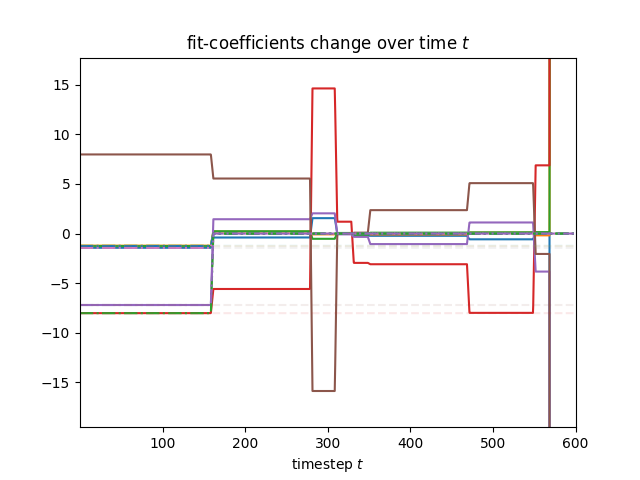

In [281]:
%matplotlib notebook
for i in range(len(time_dependent_fit_coefficients[0])):
    plt.plot(t, [time_dependent_fit_coefficients[0][i](el) for el in t], label='coefficient $p_%i$' % (i))
    if i == 5: break

for i in range(len(models[0][0].fit_coefficients[0])):
    #if 5 < i < 30: continue
    if i == 5: break
    plt.plot(t, [gamma[0](el) * models[0][0].fit_coefficients[0][i] for el in t], 
             label='original $p_%i$' % (i), linestyle='dashdot')
    plt.plot(t, [1. * models[0][0].fit_coefficients[0][i] for el in t], 
             label='original $p_%i$' % (i), linestyle='--', alpha=.1)

plt.plot(t, [1. * models[-1][0].fit_coefficients[0][i] for el in t], 
             label='original $p_%i$' % (i), linestyle='--')
        
plt.title('fit-coefficients change over time $t$')
plt.xlabel('timestep $t$')
#plt.legend()
plt.show()

In [282]:
def convert_fit_coefficients_to_function(p, grade, dimension=3):
    assert(dimension == 3)
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    #print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly, y_3_poly = cu.polynominal(dimension, grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

In [283]:
def func(t, x, p, q, r, grade):
    '''        |  |  |
               fit-coefficients,
               need to be converted to function each iteration
    '''
    fit_to_y_1 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in p]), grade)
    fit_to_y_2 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in q]), grade)
    fit_to_y_3 = convert_fit_coefficients_to_function(np.asarray([el(t) for el in r]), grade)
    
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]

    return y

In [284]:
index_start = 0#160
T = len(z_1_)
#T = 300

ivp = [0, 0, 0]
ivp[0] += z_1_[index_start]
ivp[1] += z_2_[index_start]
ivp[2] += z_3_[index_start]

In [285]:
f = 256#1024
t = np.linspace(index_start, index_start + T, T * f)

sol, infodict = odeint(func, ivp, t, 
                       args=(time_dependent_fit_coefficients[0], 
                             time_dependent_fit_coefficients[1], 
                             time_dependent_fit_coefficients[2], grade), 
                       tfirst=True, full_output=True, printmessg=True)

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d static
using 3d

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


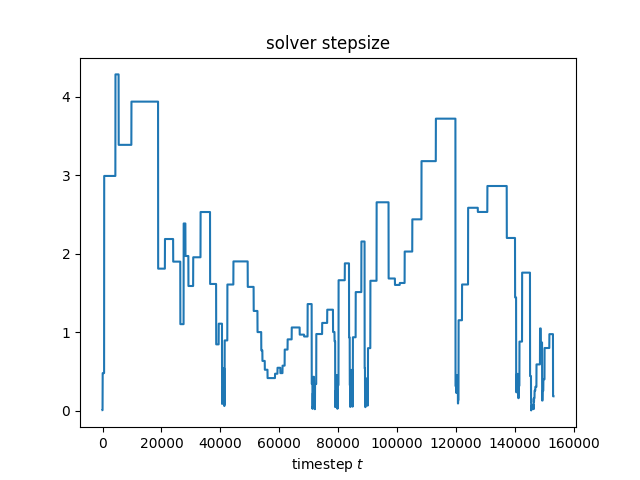

In [286]:
%matplotlib notebook
plt.plot(infodict['hu'])
plt.xlabel('timestep $t$')
plt.title('solver stepsize')
plt.show()

<IPython.core.display.Javascript object>


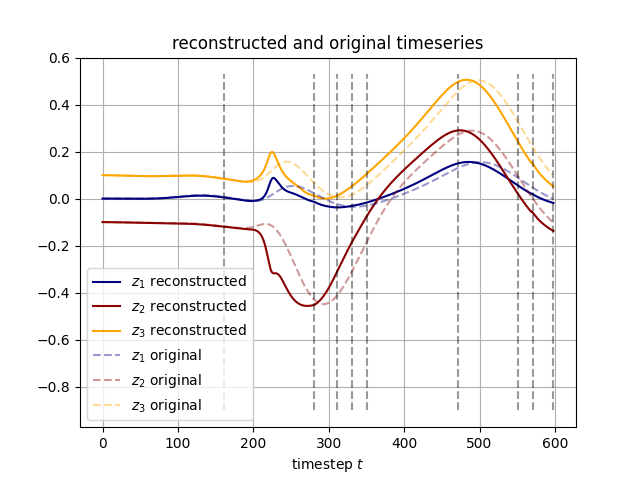

In [288]:
%matplotlib notebook
mi = -1

plt.plot(t[:mi], sol[:mi,0], label='$z_1$ reconstructed', c='navy')
plt.plot(t[:mi], sol[:mi,1], label='$z_2$ reconstructed', c='darkred')
plt.plot(t[:mi], sol[:mi,2], label='$z_3$ reconstructed', c='orange')

plt.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
plt.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
plt.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')

for i in range(len(series_intervals)):
    el = series_intervals[i]
    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
             c='black', alpha=.4, linestyle='--')

plt.title('reconstructed and original timeseries')
plt.xlabel('timestep $t$')
plt.grid()
plt.legend()

#plt.ylim([-1000,1000])

plt.show()

In [ ]:
#coefficients_ = models[0][0].fit_coefficients
#coefficients_
#print([coefficients_[i] - models[0][0].fit_coefficients[i] for i in range(len(coefficients_))])